In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

%matplotlib inline

In [97]:
x = np.linspace(50,90)
intercept = 60
slope = 300
y = intercept + slope*x + np.random.normal(0,3,size=len(x))

In [98]:
def splot(x,y):
    fig,ax = plt.subplots()
    ax.scatter(x,y)
    plt.show()
    

In [99]:
def lr(x,y):
    if len(x.shape) == 1:
        X = x[:,np.newaxis]
    else:
        X = x
    model = LinearRegression()
    model.fit(X,y)
    print("Intercept: {}, Slope: {}".format(model.intercept_,model.coef_))
    return model.intercept_,model.coef_

In [105]:
a0,b0 = lr(x,y);

Intercept: 58.594482157404855, Slope: [ 300.02477645]


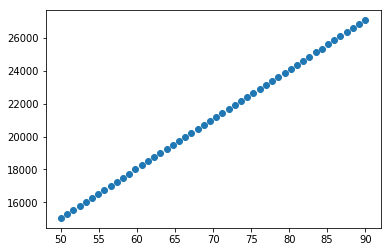

In [101]:
splot(x,y)

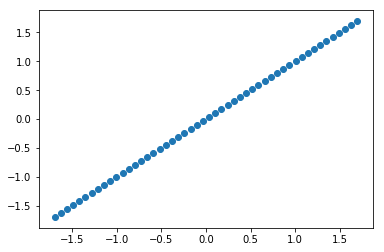

In [102]:
scalex = StandardScaler().fit(x[:,np.newaxis])
xs = scalex.transform(x[:,np.newaxis])
scaley = StandardScaler().fit(y[:,np.newaxis])
ys = scaley.transform(y[:,np.newaxis])[:,0]
splot(xs,ys)

In [106]:
a,b = lr(xs,ys)

Intercept: 4.618528082144806e-16, Slope: [ 0.9999996]


In [107]:
print(intercept,a0,(a*scaley.scale_) + y.mean() - (b*(scaley.scale_/scalex.scale_)*x.mean()))

60 58.5944821574 [ 58.59448216]


In [120]:
import pymc3 as pm
import theano.tensor as ttens
import pandas as pd

In [113]:
def linear_regression(X, y, 
                      n_features = None, n_samples = None,
                      alpha_prior = None, beta_prior = None, sigma_prior = None,
                      samples = 1000, njobs = 2):
    if not alpha_prior:
        alpha_prior = {'mu':0, 'sd':10}
    if not beta_prior:
        beta_prior = {'mu':np.zeros((n_features)), 'sd':3*np.ones((n_features))}
    if not sigma_prior:
        sigma_prior = {'sd': 3}
    if not n_features:
        n_features = X.shape[1]
    if not n_samples:
        n_samples = X.shape[0]

    with pm.Model() as model: 
        #Specify priors
        alpha = pm.Normal('alpha', mu = alpha_prior['mu'], sd = alpha_prior['sd'])
        beta = pm.Normal('beta', mu = beta_prior['mu'], sd = beta_prior['sd'], shape = int(n_features))
        sigma = pm.HalfNormal('sigma', sd = sigma_prior['sd'])
        
        # Specify regression relationship in mu
        mu = alpha + ttens.dot(beta,X.T)
        
        # Specify likelihood
        Y_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = y)
        
        # Fit the model
        trace = pm.sample(draws = samples, njobs = njobs)
        
        # Generate data from the model
        simulate_data = pm.sample_ppc(trace=trace,model=model)
    return model, trace, simulate_data

In [114]:
model, trace, simulate_data = linear_regression(xs[:,np.newaxis],ys)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 1500/1500 [00:06<00:00, 240.30it/s]
The acceptance probability does not match the target. It is 0.909026258446, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.896167383666, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 1000/1000 [00:02<00:00, 466.01it/s]


In [121]:
def _to_dataframe(trace):
    ft = pd.DataFrame()
    param_list = trace.varnames
    for idx,param_name in enumerate(param_list):
        if "." not in param_name:
            ft[param_name] = trace.get_values(param_name)
        else:
            param_short_name, feature_index = param_name.split(".")
            feature_index = int(feature_index) -1
            if len(fit.extract(param_short_name)[param_short_name].shape) < 2:
                ft[param_name] = fit.extract(param_short_name)[param_short_name]
            else:
                ft[param_name] = fit.extract(param_short_name)[param_short_name][:,feature_index]
    return ft

# Extract the samples to a dataframe called ft
ft = _to_dataframe(trace)


In [126]:
ft['alpha_original'] = scaley.mean_ - ft.beta*(scaley.scale_/scalex.scale_)*scalex.mean_
ft['beta_original'] = ft.beta*(scalex.scale_/scaley.scale_)

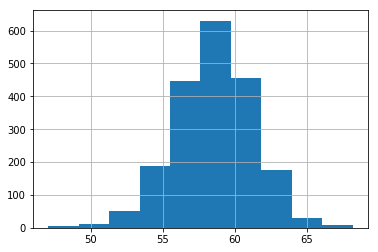

In [127]:
ft.alpha_original.hist()

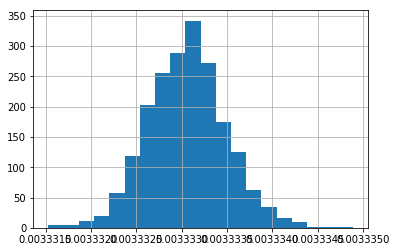

In [130]:
ft.beta_original.hist(bins=20)

In [65]:
(a*scaley.scale_)

array([ -3.47290517e-12])

In [70]:
b

array([ 0.99965192])

In [68]:
b*(scaley.scale_/scalex.scale_)*x.mean()

array([ 20925.30186394])